In [19]:
!pip install keras-tuner

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#some code for checking gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [22]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [23]:
#change dir here for loading files and metadata
root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/both"
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/processed_data.csv')

In [24]:
def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder,metadata):
  # process all folds and put them into dictionary
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            print(f"folder{fold} not found error")
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      print("wrong image shape error")
                      continue
                    image_array = normalize(image_array)
                    image_array = image_array.reshape(76,33,1)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


data = conv_array(root_folder,metadata)
input_shape = data['fold1'][0].shape
print(f"input shape is {input_shape}")

100%|██████████| 837/837 [00:02<00:00, 310.30it/s]


input shape is (873, 76, 33, 1)


In [25]:
print(data['fold1'][0][0])

tf.Tensor(
[[[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 ...

 [[0.27843137]
  [0.2745098 ]
  [0.27843137]
  ...
  [0.27058824]
  [0.27058824]
  [0.27843137]]

 [[0.27843137]
  [0.2745098 ]
  [0.27843137]
  ...
  [0.2627451 ]
  [0.27058824]
  [0.2745098 ]]

 [[1.        ]
  [0.99607843]
  [1.        ]
  ...
  [0.98823529]
  [0.99607843]
  [1.        ]]], shape=(76, 33, 1), dtype=float64)


Trial 20 Complete [00h 00m 44s]
val_loss: 1.1489558815956116

Best val_loss So Far: 1.0897361636161804
Total elapsed time: 00h 33m 56s


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/25
62/62 [==============================] - 5s 47ms/step - loss: 2.0956 - accuracy: 0.2265 - val_loss: 1.8492 - val_accuracy: 0.3517 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 3s 40ms/step - loss: 1.5619 - accuracy: 0.4378 - val_loss: 1.5366 - val_accuracy: 0.5395 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 2s 39ms/step - loss: 1.3323 - accuracy: 0.5183 - val_loss: 1.4071 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 2s 39ms/step - loss: 1.1787 - accuracy: 0.5858 - val_loss: 1.4093 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 2s 40ms/step - loss: 1.1016 - accuracy: 0.6109 - val_loss: 1.2648 - val_accuracy: 0.5968 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 2s 39ms/step - loss: 0.9797 - accuracy: 0.6592 - val_loss: 1.2297 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 7/25
62/62 [=======================

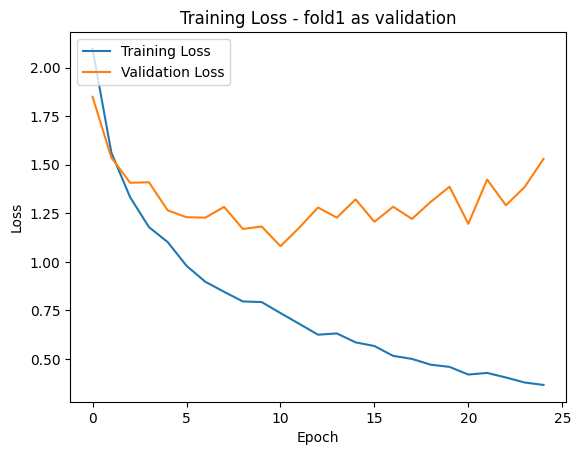

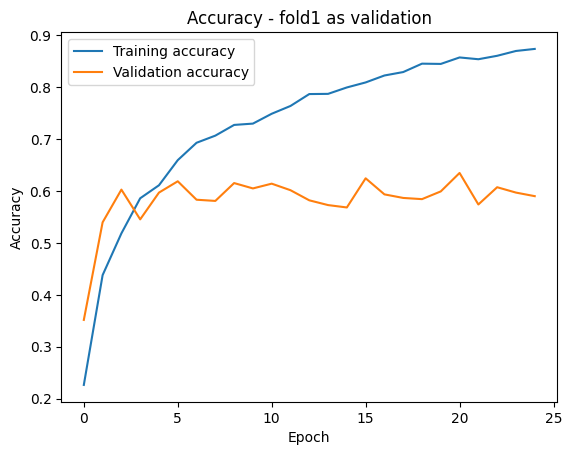

 10%|█         | 1/10 [01:29<13:29, 89.90s/it]

Training using fold2 as validation
Epoch 1/25
62/62 [==============================] - 5s 61ms/step - loss: 2.0639 - accuracy: 0.2344 - val_loss: 1.8708 - val_accuracy: 0.3649 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 3s 42ms/step - loss: 1.5009 - accuracy: 0.4581 - val_loss: 1.6031 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 2s 39ms/step - loss: 1.3470 - accuracy: 0.5223 - val_loss: 1.5107 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 2s 38ms/step - loss: 1.2414 - accuracy: 0.5623 - val_loss: 1.4602 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 2s 38ms/step - loss: 1.1062 - accuracy: 0.6170 - val_loss: 1.4360 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 2s 40ms/step - loss: 1.0285 - accuracy: 0.6439 - val_loss: 1.4242 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 7/25
62/62 [=======================

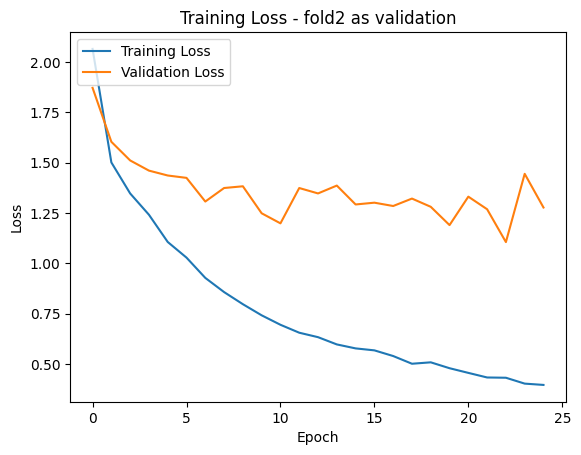

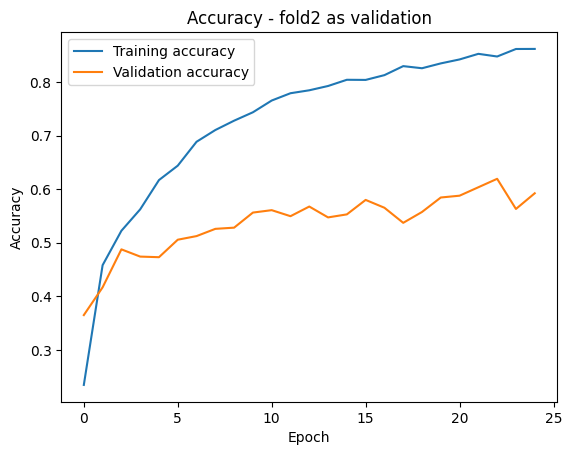

 20%|██        | 2/10 [02:59<11:58, 89.87s/it]

Training using fold3 as validation
Epoch 1/25
61/61 [==============================] - 6s 64ms/step - loss: 2.0268 - accuracy: 0.2435 - val_loss: 1.8622 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 3s 42ms/step - loss: 1.5386 - accuracy: 0.4396 - val_loss: 1.6761 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 3s 41ms/step - loss: 1.4067 - accuracy: 0.4971 - val_loss: 1.6577 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 2s 40ms/step - loss: 1.3337 - accuracy: 0.5271 - val_loss: 1.5712 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 2s 40ms/step - loss: 1.2350 - accuracy: 0.5729 - val_loss: 1.5033 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 2s 40ms/step - loss: 1.1634 - accuracy: 0.5956 - val_loss: 1.4055 - val_accuracy: 0.4789 - lr: 0.0010
Epoch 7/25
61/61 [=======================

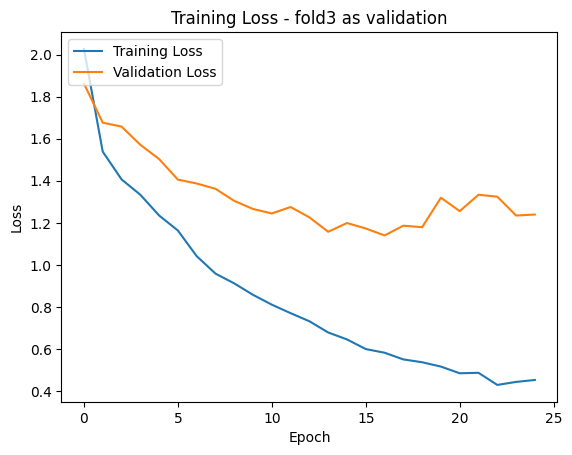

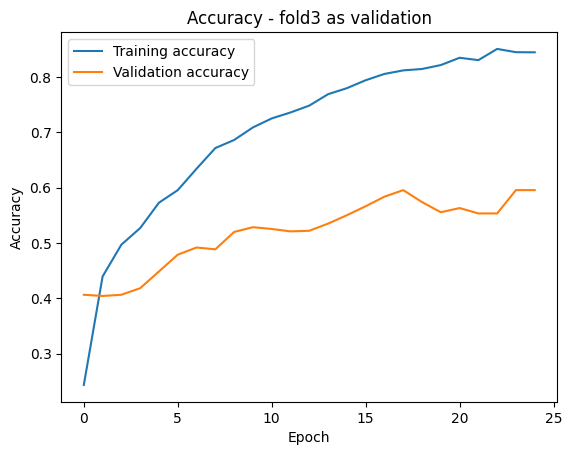

 30%|███       | 3/10 [04:29<10:29, 89.87s/it]

Training using fold4 as validation
Epoch 1/25
61/61 [==============================] - 5s 59ms/step - loss: 2.0476 - accuracy: 0.2441 - val_loss: 1.8740 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 3s 42ms/step - loss: 1.4763 - accuracy: 0.4681 - val_loss: 1.6622 - val_accuracy: 0.4071 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 2s 41ms/step - loss: 1.3015 - accuracy: 0.5385 - val_loss: 1.5462 - val_accuracy: 0.4535 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 2s 39ms/step - loss: 1.1930 - accuracy: 0.5831 - val_loss: 1.6154 - val_accuracy: 0.4535 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 2s 41ms/step - loss: 1.0791 - accuracy: 0.6228 - val_loss: 1.4331 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 2s 40ms/step - loss: 0.9683 - accuracy: 0.6617 - val_loss: 1.4476 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 7/25
61/61 [=======================

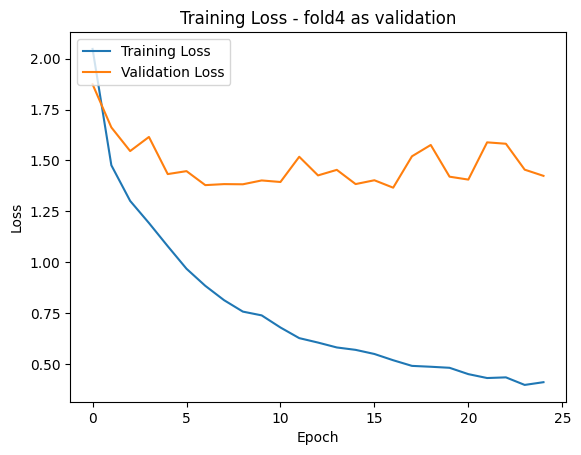

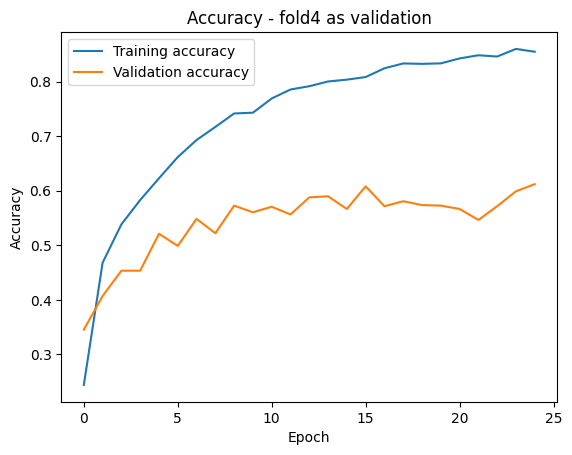

 40%|████      | 4/10 [05:41<08:15, 82.58s/it]

Training using fold5 as validation
Epoch 1/25
61/61 [==============================] - 6s 63ms/step - loss: 2.0750 - accuracy: 0.2385 - val_loss: 1.8767 - val_accuracy: 0.2949 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 2s 39ms/step - loss: 1.5744 - accuracy: 0.4271 - val_loss: 1.5793 - val_accuracy: 0.4412 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 2s 40ms/step - loss: 1.3562 - accuracy: 0.5113 - val_loss: 1.3921 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 2s 41ms/step - loss: 1.2361 - accuracy: 0.5609 - val_loss: 1.2869 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 3s 42ms/step - loss: 1.0878 - accuracy: 0.6216 - val_loss: 1.2541 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 2s 41ms/step - loss: 1.0088 - accuracy: 0.6539 - val_loss: 1.1718 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 7/25
61/61 [=======================

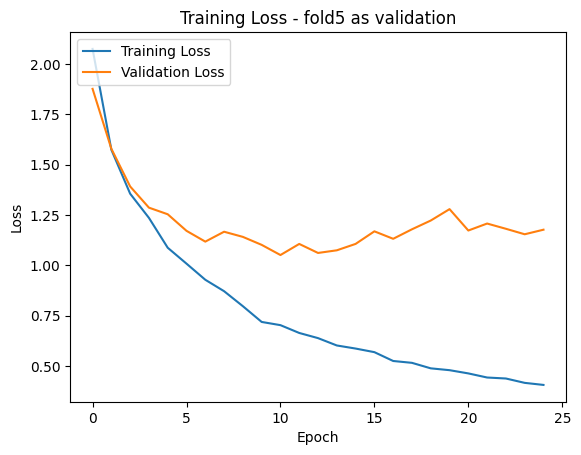

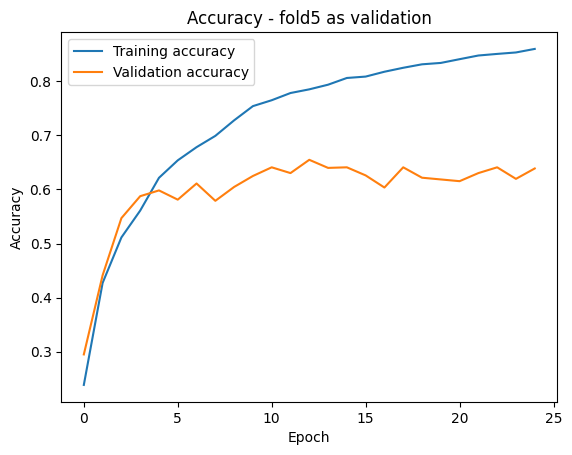

 50%|█████     | 5/10 [07:13<07:10, 86.19s/it]

Training using fold6 as validation
Epoch 1/25
62/62 [==============================] - 6s 63ms/step - loss: 2.1080 - accuracy: 0.2319 - val_loss: 1.8407 - val_accuracy: 0.3062 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 2s 39ms/step - loss: 1.6222 - accuracy: 0.3975 - val_loss: 1.6253 - val_accuracy: 0.4034 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 3s 41ms/step - loss: 1.3877 - accuracy: 0.5017 - val_loss: 1.4788 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 2s 39ms/step - loss: 1.2891 - accuracy: 0.5413 - val_loss: 1.3992 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 3s 41ms/step - loss: 1.1991 - accuracy: 0.5772 - val_loss: 1.3918 - val_accuracy: 0.5079 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 3s 41ms/step - loss: 1.1333 - accuracy: 0.6064 - val_loss: 1.3055 - val_accuracy: 0.5443 - lr: 0.0010
Epoch 7/25
62/62 [=======================

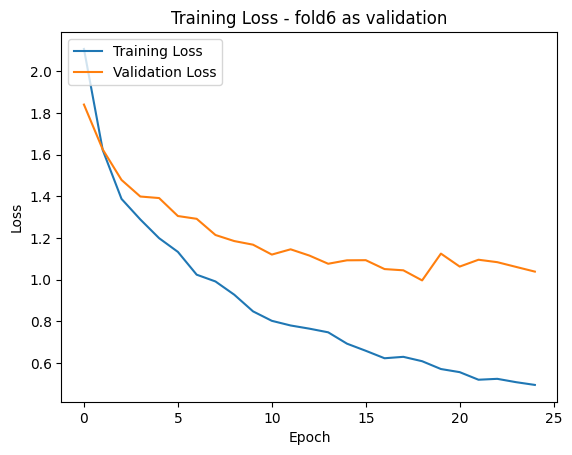

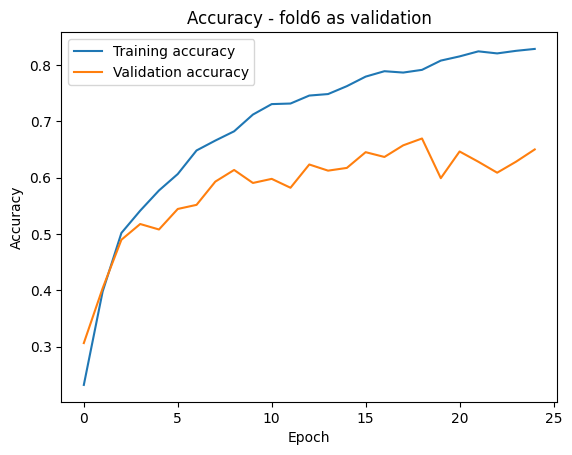

 60%|██████    | 6/10 [08:43<05:50, 87.57s/it]

Training using fold7 as validation
Epoch 1/25
62/62 [==============================] - 6s 63ms/step - loss: 2.0635 - accuracy: 0.2374 - val_loss: 1.8412 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 3s 41ms/step - loss: 1.5518 - accuracy: 0.4325 - val_loss: 1.5945 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 2s 40ms/step - loss: 1.3732 - accuracy: 0.5024 - val_loss: 1.4014 - val_accuracy: 0.5024 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 2s 39ms/step - loss: 1.2453 - accuracy: 0.5526 - val_loss: 1.3534 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 3s 40ms/step - loss: 1.1403 - accuracy: 0.5902 - val_loss: 1.3494 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 2s 40ms/step - loss: 1.0171 - accuracy: 0.6476 - val_loss: 1.2469 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 7/25
62/62 [=======================

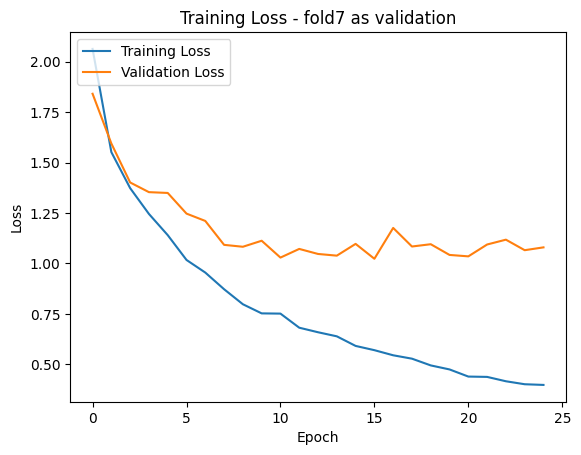

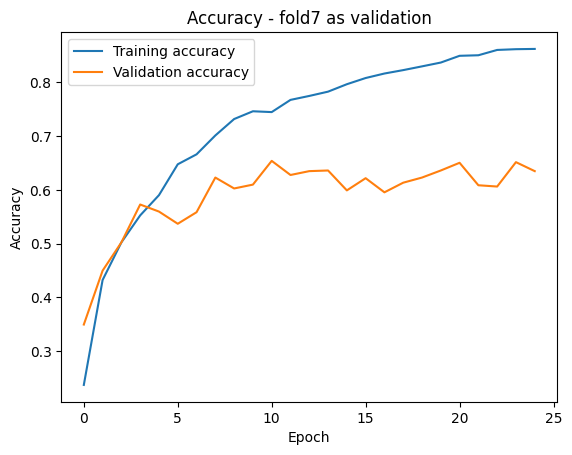

 70%|███████   | 7/10 [09:56<04:07, 82.65s/it]

Training using fold8 as validation
Epoch 1/25
62/62 [==============================] - 5s 61ms/step - loss: 2.0997 - accuracy: 0.2316 - val_loss: 1.7913 - val_accuracy: 0.3797 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 2s 39ms/step - loss: 1.6007 - accuracy: 0.4060 - val_loss: 1.4918 - val_accuracy: 0.5335 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 3s 42ms/step - loss: 1.3847 - accuracy: 0.5082 - val_loss: 1.5345 - val_accuracy: 0.4553 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 3s 42ms/step - loss: 1.2844 - accuracy: 0.5418 - val_loss: 1.5353 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 2s 40ms/step - loss: 1.2257 - accuracy: 0.5699 - val_loss: 1.4816 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 2s 39ms/step - loss: 1.1742 - accuracy: 0.5898 - val_loss: 1.4794 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 7/25
62/62 [=======================

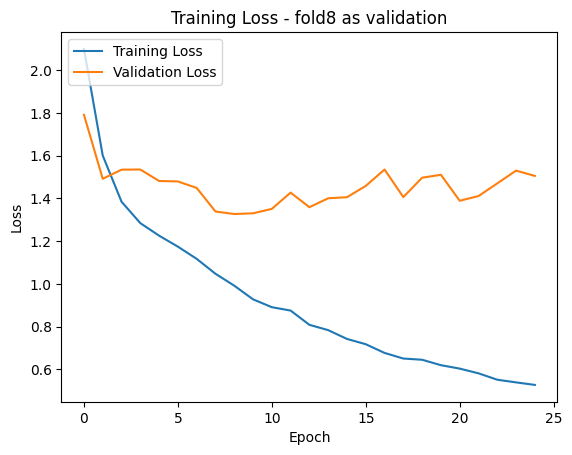

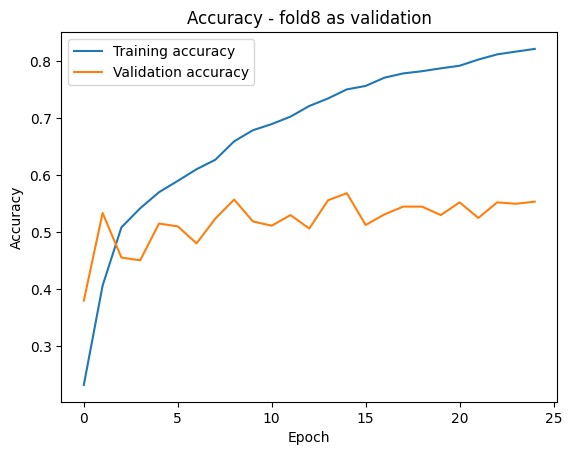

 80%|████████  | 8/10 [11:10<02:39, 79.86s/it]

Training using fold9 as validation
Epoch 1/25
62/62 [==============================] - 6s 64ms/step - loss: 2.1213 - accuracy: 0.2279 - val_loss: 1.8891 - val_accuracy: 0.3064 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 2s 39ms/step - loss: 1.6164 - accuracy: 0.4197 - val_loss: 1.6241 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 2s 39ms/step - loss: 1.4020 - accuracy: 0.5153 - val_loss: 1.5546 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 3s 40ms/step - loss: 1.2412 - accuracy: 0.5720 - val_loss: 1.4287 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 2s 39ms/step - loss: 1.1551 - accuracy: 0.5959 - val_loss: 1.3803 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 3s 41ms/step - loss: 1.0519 - accuracy: 0.6377 - val_loss: 1.2683 - val_accuracy: 0.5980 - lr: 0.0010
Epoch 7/25
62/62 [=======================

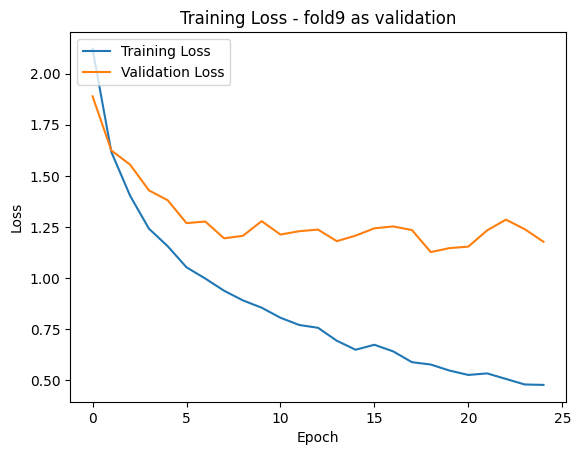

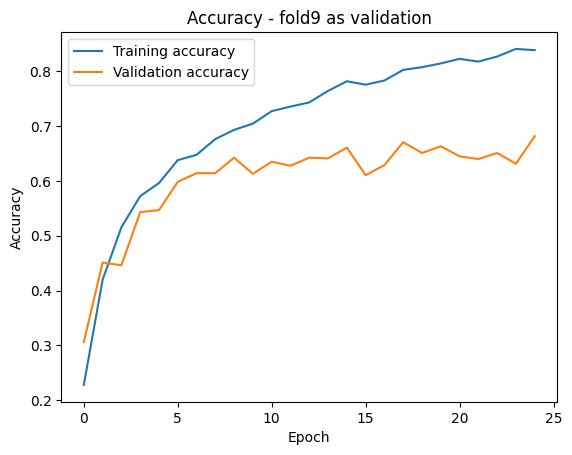

 90%|█████████ | 9/10 [12:23<01:17, 77.76s/it]

Training using fold10 as validation
Epoch 1/25
62/62 [==============================] - 5s 59ms/step - loss: 1.9635 - accuracy: 0.2851 - val_loss: 1.7835 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 2s 39ms/step - loss: 1.4325 - accuracy: 0.4828 - val_loss: 1.5897 - val_accuracy: 0.4827 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 3s 42ms/step - loss: 1.2334 - accuracy: 0.5739 - val_loss: 1.4555 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 3s 41ms/step - loss: 1.0976 - accuracy: 0.6123 - val_loss: 1.3857 - val_accuracy: 0.5783 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 2s 40ms/step - loss: 0.9997 - accuracy: 0.6550 - val_loss: 1.2973 - val_accuracy: 0.6081 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 2s 40ms/step - loss: 0.8862 - accuracy: 0.6927 - val_loss: 1.1579 - val_accuracy: 0.6499 - lr: 0.0010
Epoch 7/25
62/62 [======================

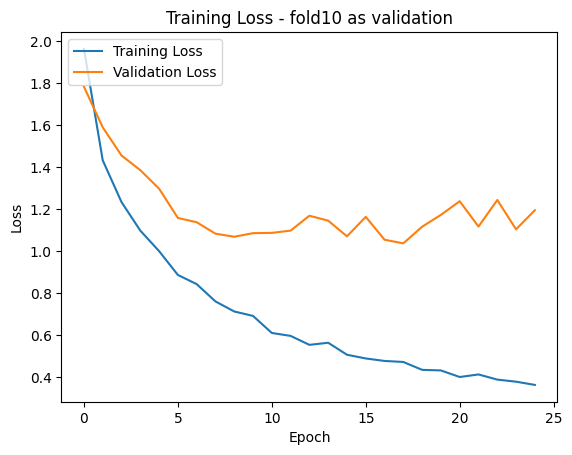

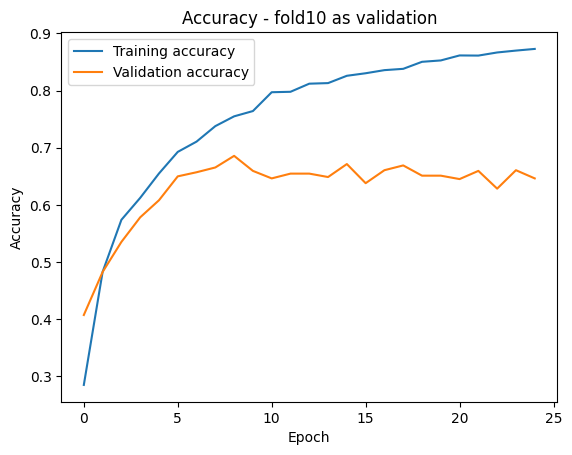

100%|██████████| 10/10 [13:37<00:00, 81.72s/it]

List of scores[0.5899198055267334, 0.5923423171043396, 0.5956756472587585, 0.6121212244033813, 0.6388888955116272, 0.650060772895813, 0.6348448395729065, 0.5533498525619507, 0.6813725233078003, 0.6463560461997986]
Average accuracy: 0.6194931924343109 has standard deviation 0.03564439067996047
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 74, 31, 32)        320       
                                                                 
 activation (Activation)     (None, 74, 31, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 13, 160)       46240     
                                                                 
 activation_1 (Activation)   (None, 35, 13, 160)       0         
                                                                 
 dropout (Dropout)           (None, 35, 13, 160)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 11, 192)       276672    
                                                                 
 activatio

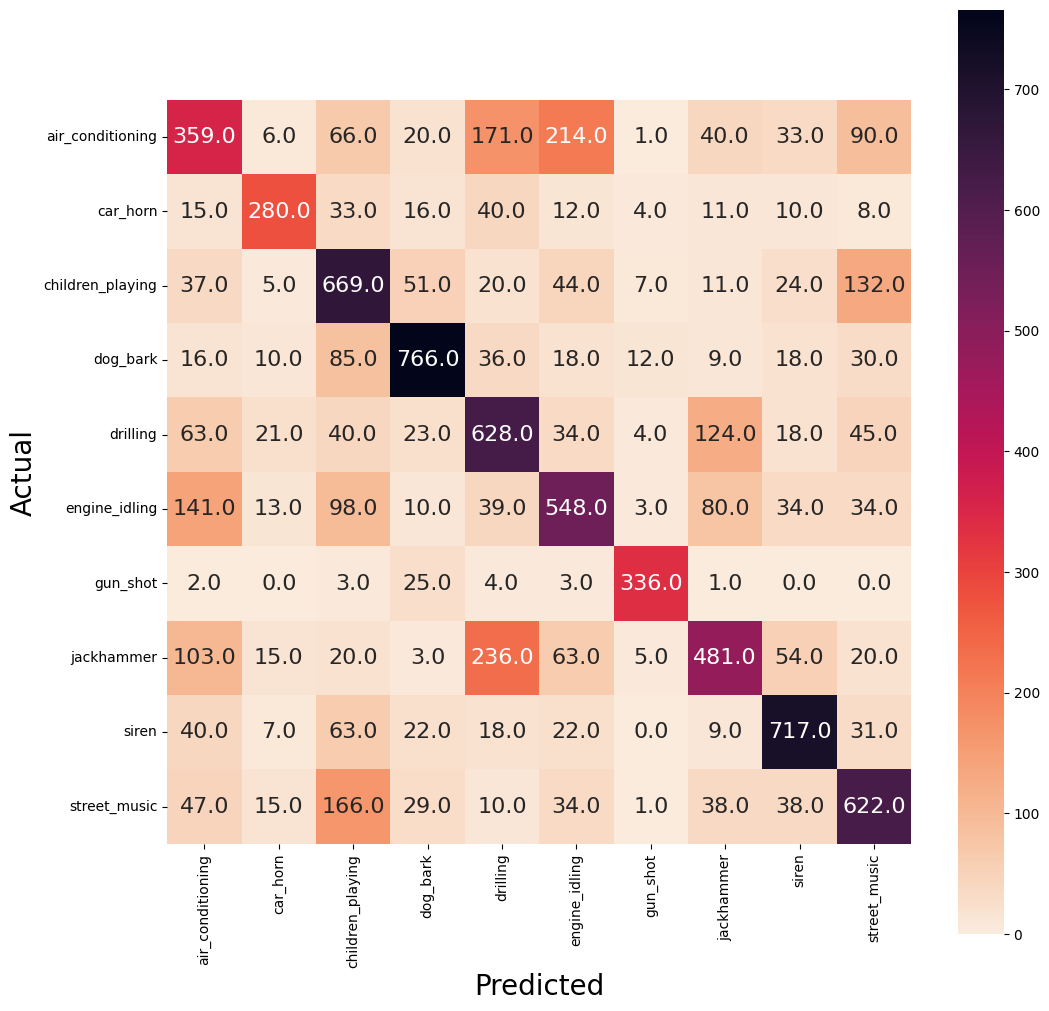

In [26]:
tensorflow.keras.backend.clear_session()

def build_model(hp):
    model = Sequential()
    input_shape = data['fold1'][0].shape[1:]

    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32), (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers, this parameter will have a convnet with 2–5 convolutions
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), (3, 3)))
        model.add(Activation('relu'))
        # adding dropout
        model.add(tensorflow.keras.layers.Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('tanh'))

    model.add(Dense(10))
    model.add(Activation("softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-3), #optimization algorithm used is Adam
                  loss=loss,
                  metrics=[metric])

    return model


#get optimal hyperparameters using
def tuner(num_epoch, batch_size,max_trials,trial_retrys):
  fold_name = "fold1"
  print(f"Training using {fold_name} as validation")
  X_val, y_val = data[fold_name][0], data[fold_name][1]
  X_train = []
  y_train = []

  for other_fold_name, other_fold_data in data.items():
    if other_fold_name == fold_name:
        continue

    X = other_fold_data[0]
    y = other_fold_data[1]
    X_train.extend(X)
    y_train.extend(y)

  X_train = np.array(X_train)
  y_train = np.array(y_train)
  EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)
  tuner = RandomSearch(build_model, objective=objective, max_trials=max_trials, executions_per_trial=trial_retrys, metrics=[metric])
  tuner.search(x=X_train, y=y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[EarlyStoppingCallback]) #10% is validation data
  best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
  return best_hyperparameters



def model_k_cross(hyperparameters, data):
    hp = kt.HyperParameters()
    list_scores = []
    Ytrue_list = []  # Use lists to store predictions
    Ypred_list = []

    for key, value in hyperparameters.items():
        hp.Fixed(key, value)

    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        cmodel = build_model(hp)
        cmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)

        history = cmodel.fit(X_train, y_train, epochs=num_epoch, batch_size=batch_size,
                             callbacks=[anne], validation_data=(X_val, y_val)) # we dont use the EarlyStoppingCallback here for the sake of plotting

        # Evaluation
        scores = cmodel.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])

        Ypred_it = cmodel.predict(X_val)
        Ypred_it = np.argmax(Ypred_it, axis=1)
        Ytrue_it = np.argmax(y_val, axis=1)
        Ytrue_list.extend(Ytrue_it.tolist())  # Append predictions to lists
        Ypred_list.extend(Ypred_it.tolist())


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()

       # Convert lists to NumPy arrays after the loop
    Ytrue = np.array(Ytrue_list)
    Ypred = np.array(Ypred_list)

    average_acc = sum(list_scores) / len(list_scores)
    accuracy_std = np.std(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc} has standard deviation {accuracy_std}')


    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    cmodel.summary()



#creating custom hyperparameters to inspect model performance,inspired by the network we found on kaggle
custom_hyperparameters = {
        'input_units': 224,
        'n_layers': 4,
        'conv_0_units': 64,
        'rate': 0.2,
        'n_connections': 3,
        'n_nodes': 1012,
        'conv_1_units': 128,
        "conv_2_units": 64,
        "conv_3_units": 160
    }


metric = 'accuracy' #evaluation metric
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 25
batch_size = 128
early_stop = 3 # early stoppping after 3 epochs with no improvement of test data

#objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.
objective='val_loss'
max_trials = 20 # how many model variations to test?
trial_retrys = 2 # how many trials per variation? (same model could perform differently)



best_hyperparameters_overall = tuner(num_epoch,batch_size,max_trials,trial_retrys)
model_k_cross(best_hyperparameters_overall, data)
print(best_hyperparameters_overall)
#model_k_cross(custom_hyperparameters, data)

